In [1]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# AutoML optuna library
import optuna
import optuna.integration.lightgbm as lgb

# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metric
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## for PCA
from sklearn.decomposition import PCA

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv('df_20200324_2.csv', index_col = 0)

In [3]:
date = data.date

In [4]:
target = data['KRXsemiconductor_close']

In [5]:
data.drop(['date', 'KRXsemiconductor_close'], axis = 1, inplace = True)

In [6]:
# scaling 하기전에 columns 뽑기 
col_name = data.columns

In [7]:
# scaling과 동시에 변환
data = StandardScaler().fit_transform(data)


In [8]:
# scaling하면 colname사라지므로 다시 생성
data = pd.DataFrame(data, columns = col_name)

In [10]:
# extract X_data
X_data = data.copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [15]:
len(X_train)

2384

In [ ]:
2384

In [16]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

In [17]:
len(x_train)

1907

In [9]:
## Feature Selection Code
# Forward stepwise feature selection
# linear model 기준으로 유효 feature 뽑기. 돌리지 않아도 되는 코드

np.random.seed(0)

feature_name = list(x_train.columns)
feature_selected = []
score = []

for i in range(x_train.shape[1]):
    score_temp_list = np.zeros(len(feature_name))
    for j in range(len(feature_name)):
        temp = feature_selected.copy() 
        temp.append(feature_name[j])
        x_temp = x_train[temp]
        lr_temp = LinearRegression() 
        lr_temp.fit(x_temp, y_train)
        predict_temp = lr_temp.predict(x_val[temp])
        r2_temp = r2_score(y_val, predict_temp)
        score_temp = r2_temp
        score_temp_list[j] = score_temp 
        
    temp = feature_name[score_temp_list.argmax()]
    feature_selected.append(temp)
    feature_name.remove(temp)
    score.append(score_temp_list.max())
    print("%02d Selected: "%i, feature_selected)
    print("%02d Score : "%i, np.round(10000*np.array(score))/10000)
        
# finally selected features
feature_selected_final = feature_selected[:(np.array(score).argmax() + 1)]

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-9-d66f49ae4053>, line 32)

# 변수 추출 완료

In [12]:
data['KRXsemiconductor_close'] = target

In [13]:
a, b = dmatrices('KRXsemiconductor_close ~ ECIYOYIndex120+ IXKIndex260+ AMD_close260+ SKBSICSAIndex120+ SKhynix_close120+ SKLIIMPTIndex120+ GDPCQOQIndex+ KOHOINCIndex120+ SKCITTLIndex120+ KOIPOPSMIndex+ KOBONTLIndex120+ SKLIMORDIndex+ CHPMINDXIndex+ TokyoElectron_close260+ KOULMGFIndex120+ CPMINORDIndex120+ FDIDSGMOIndex120+ KOFDITIndex120+ CPIYOYIndex120+ USTBIMPIndex+ NAPMNEWOIndex120+ PITLCHNGIndex+ KOHOINCYIndex120+ KOVMTOTSIndex+ FRNTTOTLIndex', data, return_type = 'dataframe')

In [15]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns 
vif

,VIF Factor,features
0,1.000000,Intercept
1,4.389662,ECIYOYIndex120
2,6.184658,IXKIndex260
3,2.976100,AMD_close260
4,7.343574,SKBSICSAIndex120
5,2.314148,SKhynix_close120
6,5.283509,SKLIIMPTIndex120
7,3.271051,GDPCQOQIndex
8,3.116846,KOHOINCIndex120
9,2.963567,SKCITTLIndex120


In [16]:
vif.drop(0, inplace = True)

In [17]:
vif.sort_values(by = 'VIF Factor', inplace = True)

In [18]:
vif_columns = vif[vif['VIF Factor']  <=  10].features

In [19]:
list(vif_columns)

['FDIDSGMOIndex120',
 'PITLCHNGIndex',
 'FRNTTOTLIndex',
 'KOIPOPSMIndex',
 'KOBONTLIndex120',
 'KOHOINCYIndex120',
 'KOVMTOTSIndex',
 'KOFDITIndex120',
 'SKhynix_close120',
 'KOULMGFIndex120',
 'USTBIMPIndex',
 'SKCITTLIndex120',
 'AMD_close260',
 'KOHOINCIndex120',
 'TokyoElectron_close260',
 'GDPCQOQIndex',
 'SKLIMORDIndex',
 'ECIYOYIndex120',
 'CPIYOYIndex120',
 'CHPMINDXIndex',
 'CPMINORDIndex120',
 'SKLIIMPTIndex120',
 'IXKIndex260',
 'NAPMNEWOIndex120',
 'SKBSICSAIndex120']

In [20]:
len(vif_columns)

25

In [22]:
X_data = X_data[list(vif_columns)]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size = 0.2, shuffle = False)

In [26]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

In [28]:
x_train.shape, x_val.shape, y_train.shape

((1907, 25), (477, 25), (1907,))

In [29]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

# Linear Model

In [30]:
# linear model select
lr_reg = LinearRegression()
#lasso = Lasso(alpha = 100)

In [31]:
lr_reg.fit(x_train, y_train)
y_pred = lr_reg.predict(x_val)

In [32]:
metr = CustomMetric(y_pred, y_val)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.983687,0.9672,0.0229,0.0289,0.960168,1.0


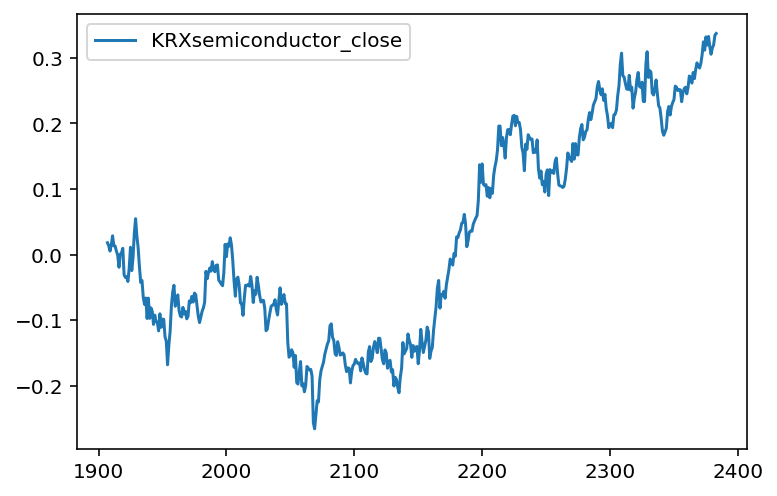

In [34]:
pd.DataFrame(y_val).plot()

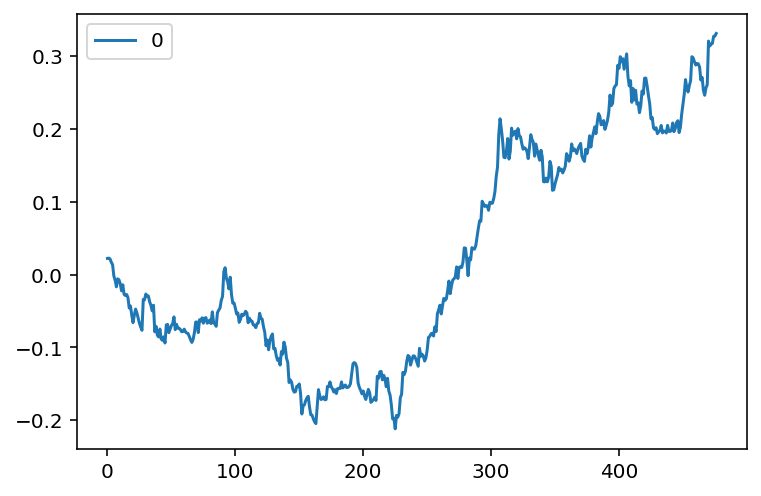

In [35]:
pd.DataFrame(y_pred).plot()

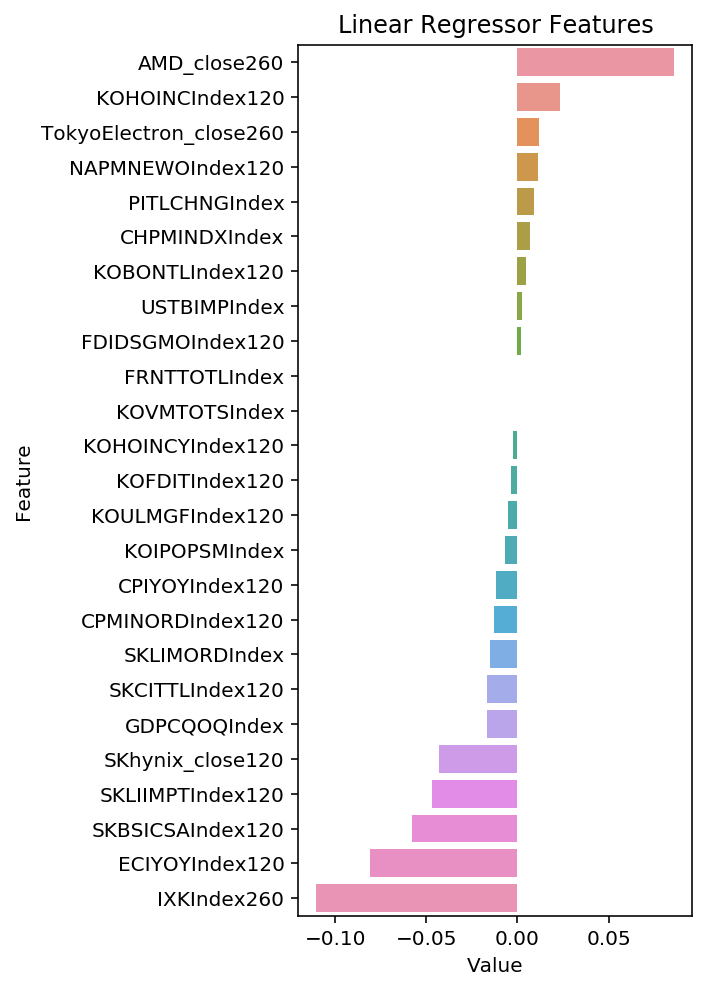

In [36]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (5, 7))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

Tree Model은 feature importance가 따로 뽑히므로 아래와 같이 시각화

# Optuna AutoML을 통한 LightGBM Hyperparameter tuning

In [70]:
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import r2_score
import optuna
import optuna.integration.lightgbm as lgb

In [71]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

best_params, tuning_history = dict(), list()

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dval],
                  best_params=best_params,
                  tuning_history=tuning_history,
                  verbose_eval=100,
                  early_stopping_rounds=100,
                  )

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
r2_score = r2_score(y_test, prediction)

print('Number of finished trials: {}'.format(len(tuning_history)))
print('Best params:', best_params)
print('  r2_score = {}'.format(r2_score))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00015567	valid_1's l2: 0.0193989
Early stopping, best iteration is:
[34]	training's l2: 0.000675782	valid_1's l2: 0.0192359


tune_feature_fraction, val_score: 0.019236:  14%|#4        | 1/7 [00:00<00:01,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000147979	valid_1's l2: 0.0186001
Early stopping, best iteration is:
[68]	training's l2: 0.000258348	valid_1's l2: 0.0185607


tune_feature_fraction, val_score: 0.018561:  29%|##8       | 2/7 [00:00<00:01,  3.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00014357	valid_1's l2: 0.0216644
Early stopping, best iteration is:
[70]	training's l2: 0.000239907	valid_1's l2: 0.0215788


tune_feature_fraction, val_score: 0.018561:  43%|####2     | 3/7 [00:01<00:01,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000141243	valid_1's l2: 0.0241512
Early stopping, best iteration is:
[2]	training's l2: 0.0215168	valid_1's l2: 0.0232434


tune_feature_fraction, val_score: 0.018561:  57%|#####7    | 4/7 [00:01<00:00,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000141878	valid_1's l2: 0.0199886
Early stopping, best iteration is:
[24]	training's l2: 0.00110045	valid_1's l2: 0.0198214


tune_feature_fraction, val_score: 0.018561:  71%|#######1  | 5/7 [00:01<00:00,  3.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00013882	valid_1's l2: 0.0224962
Early stopping, best iteration is:
[1]	training's l2: 0.0258902	valid_1's l2: 0.0218251


tune_feature_fraction, val_score: 0.018561:  86%|########5 | 6/7 [00:01<00:00,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000140012	valid_1's l2: 0.0208716
Early stopping, best iteration is:
[28]	training's l2: 0.000857043	valid_1's l2: 0.0204297


tune_num_leaves, val_score: 0.018561:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.94521e-05	valid_1's l2: 0.0193709
Early stopping, best iteration is:
[42]	training's l2: 0.000134407	valid_1's l2: 0.019309


tune_num_leaves, val_score: 0.018561:   5%|5         | 1/20 [00:00<00:14,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.93065e-05	valid_1's l2: 0.0185373
Early stopping, best iteration is:
[42]	training's l2: 0.000298673	valid_1's l2: 0.018478


tune_num_leaves, val_score: 0.018478:  10%|#         | 2/20 [00:01<00:12,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75484e-05	valid_1's l2: 0.0190913
Early stopping, best iteration is:
[20]	training's l2: 0.000793456	valid_1's l2: 0.0189196


tune_num_leaves, val_score: 0.018478:  15%|#5        | 3/20 [00:02<00:11,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.84519e-05	valid_1's l2: 0.0190631
Early stopping, best iteration is:
[27]	training's l2: 0.00033675	valid_1's l2: 0.0189762


tune_num_leaves, val_score: 0.018478:  20%|##        | 4/20 [00:02<00:11,  1.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75188e-05	valid_1's l2: 0.0190869
Early stopping, best iteration is:
[29]	training's l2: 0.000279964	valid_1's l2: 0.0189727


tune_num_leaves, val_score: 0.018478:  25%|##5       | 5/20 [00:03<00:11,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75484e-05	valid_1's l2: 0.0190913
Early stopping, best iteration is:
[20]	training's l2: 0.000793456	valid_1's l2: 0.0189196


tune_num_leaves, val_score: 0.018478:  30%|###       | 6/20 [00:04<00:10,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 4.96776e-05	valid_1's l2: 0.0185448
[200]	training's l2: 7.65737e-06	valid_1's l2: 0.0185538
Early stopping, best iteration is:
[110]	training's l2: 4.01551e-05	valid_1's l2: 0.0185143


tune_num_leaves, val_score: 0.018478:  35%|###5      | 7/20 [00:05<00:09,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.84481e-05	valid_1's l2: 0.0184814
Early stopping, best iteration is:
[50]	training's l2: 9.13493e-05	valid_1's l2: 0.0184454


tune_num_leaves, val_score: 0.018445:  40%|####      | 8/20 [00:05<00:09,  1.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.01464e-05	valid_1's l2: 0.0189739
Early stopping, best iteration is:
[66]	training's l2: 5.1933e-05	valid_1's l2: 0.0189607


tune_num_leaves, val_score: 0.018445:  45%|####5     | 9/20 [00:06<00:09,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75484e-05	valid_1's l2: 0.0190913
Early stopping, best iteration is:
[20]	training's l2: 0.000793456	valid_1's l2: 0.0189196


tune_num_leaves, val_score: 0.018445:  50%|#####     | 10/20 [00:07<00:08,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75484e-05	valid_1's l2: 0.0190913
Early stopping, best iteration is:
[20]	training's l2: 0.000793456	valid_1's l2: 0.0189196


tune_num_leaves, val_score: 0.018445:  55%|#####5    | 11/20 [00:08<00:07,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000680357	valid_1's l2: 0.0200379
Early stopping, best iteration is:
[21]	training's l2: 0.00393315	valid_1's l2: 0.0193558


tune_num_leaves, val_score: 0.018445:  60%|######    | 12/20 [00:08<00:05,  1.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.80857e-05	valid_1's l2: 0.0180618
[200]	training's l2: 9.50627e-06	valid_1's l2: 0.0180036
[300]	training's l2: 2.13058e-06	valid_1's l2: 0.0180055
Early stopping, best iteration is:
[209]	training's l2: 8.20648e-06	valid_1's l2: 0.0179997


tune_num_leaves, val_score: 0.018000:  65%|######5   | 13/20 [00:09<00:05,  1.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.65729e-05	valid_1's l2: 0.0186405
Early stopping, best iteration is:
[49]	training's l2: 0.000156302	valid_1's l2: 0.0185928


tune_num_leaves, val_score: 0.018000:  70%|#######   | 14/20 [00:10<00:04,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000620226	valid_1's l2: 0.0190999
Early stopping, best iteration is:
[39]	training's l2: 0.00159617	valid_1's l2: 0.0187363


tune_num_leaves, val_score: 0.018000:  75%|#######5  | 15/20 [00:10<00:02,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.56224e-05	valid_1's l2: 0.0193734
Early stopping, best iteration is:
[74]	training's l2: 5.27672e-05	valid_1's l2: 0.0193445


tune_num_leaves, val_score: 0.018000:  80%|########  | 16/20 [00:11<00:02,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000137887	valid_1's l2: 0.0191807
Early stopping, best iteration is:
[77]	training's l2: 0.000206186	valid_1's l2: 0.0190867


tune_num_leaves, val_score: 0.018000:  85%|########5 | 17/20 [00:11<00:01,  1.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.30008e-05	valid_1's l2: 0.0189961
[200]	training's l2: 3.18371e-06	valid_1's l2: 0.0190195
Early stopping, best iteration is:
[107]	training's l2: 1.91446e-05	valid_1's l2: 0.0189884


tune_num_leaves, val_score: 0.018000:  90%|######### | 18/20 [00:12<00:01,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.75484e-05	valid_1's l2: 0.0190913
Early stopping, best iteration is:
[20]	training's l2: 0.000793456	valid_1's l2: 0.0189196


tune_num_leaves, val_score: 0.018000:  95%|#########5| 19/20 [00:13<00:00,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00012047	valid_1's l2: 0.0197394
[200]	training's l2: 3.06658e-05	valid_1's l2: 0.0196516
[300]	training's l2: 9.74578e-06	valid_1's l2: 0.0197
Early stopping, best iteration is:
[214]	training's l2: 2.61849e-05	valid_1's l2: 0.0196395


tune_num_leaves, val_score: 0.018000: 100%|##########| 20/20 [00:14<00:00,  1.42it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.67671e-05	valid_1's l2: 0.0215284
Early stopping, best iteration is:
[60]	training's l2: 0.000183208	valid_1's l2: 0.0214395


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  10%|#         | 1/10 [00:00<00:03,  2.27it/s][I 2020-03-19 22:05:01,086] Finished trial#0 resulted in value: 0.021439479630631277. Current best value is 0.021439479630631277 with parameters: {'bagging_fraction': 0.7408429123224262, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  10%|#         | 1/10 [00:00<00:03,  2.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.69687e-05	valid_1's l2: 0.0185348
[200]	training's l2: 9.44743e-06	valid_1's l2: 0.0185046
Early stopping, best iteration is:
[159]	training's l2: 1.87899e-05	valid_1's l2: 0.01849


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  20%|##        | 2/10 [00:01<00:04,  1.86it/s][I 2020-03-19 22:05:01,847] Finished trial#1 resulted in value: 0.0184899823854152. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  20%|##        | 2/10 [00:01<00:04,  1.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000142227	valid_1's l2: 0.0199452
Early stopping, best iteration is:
[92]	training's l2: 0.000160855	valid_1's l2: 0.0199152


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  30%|###       | 3/10 [00:01<00:03,  1.89it/s][I 2020-03-19 22:05:02,355] Finished trial#2 resulted in value: 0.019915182181721374. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  30%|###       | 3/10 [00:01<00:03,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.27201e-05	valid_1's l2: 0.0199592
Early stopping, best iteration is:
[55]	training's l2: 0.000221228	valid_1's l2: 0.0197982


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  40%|####      | 4/10 [00:02<00:03,  1.91it/s][I 2020-03-19 22:05:02,873] Finished trial#3 resulted in value: 0.01979817873325879. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  40%|####      | 4/10 [00:02<00:03,  1.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.74262e-05	valid_1's l2: 0.0205009
Early stopping, best iteration is:
[19]	training's l2: 0.00134095	valid_1's l2: 0.0203466


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  50%|#####     | 5/10 [00:02<00:02,  2.02it/s][I 2020-03-19 22:05:03,300] Finished trial#4 resulted in value: 0.02034655050143635. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  50%|#####     | 5/10 [00:02<00:02,  2.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.04019e-05	valid_1's l2: 0.0211446
Early stopping, best iteration is:
[7]	training's l2: 0.00835492	valid_1's l2: 0.0209133


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  60%|######    | 6/10 [00:03<00:01,  2.18it/s][I 2020-03-19 22:05:03,672] Finished trial#5 resulted in value: 0.0209133285645976. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  60%|######    | 6/10 [00:03<00:01,  2.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.2308e-05	valid_1's l2: 0.0200851
Early stopping, best iteration is:
[12]	training's l2: 0.00359676	valid_1's l2: 0.0193316


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  70%|#######   | 7/10 [00:03<00:01,  2.24it/s][I 2020-03-19 22:05:04,088] Finished trial#6 resulted in value: 0.019331599927083325. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  70%|#######   | 7/10 [00:03<00:01,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.20356e-05	valid_1's l2: 0.0200718
Early stopping, best iteration is:
[73]	training's l2: 0.000125396	valid_1's l2: 0.0200002


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  80%|########  | 8/10 [00:03<00:00,  2.13it/s][I 2020-03-19 22:05:04,609] Finished trial#7 resulted in value: 0.02000020560343998. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  80%|########  | 8/10 [00:04<00:00,  2.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000153419	valid_1's l2: 0.0195759
[200]	training's l2: 5.28327e-05	valid_1's l2: 0.0195756
Early stopping, best iteration is:
[146]	training's l2: 8.79216e-05	valid_1's l2: 0.0195185


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  90%|######### | 9/10 [00:04<00:00,  1.89it/s][I 2020-03-19 22:05:05,285] Finished trial#8 resulted in value: 0.01951853299973461. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000:  90%|######### | 9/10 [00:04<00:00,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.98846e-05	valid_1's l2: 0.0195
Early stopping, best iteration is:
[19]	training's l2: 0.00129429	valid_1's l2: 0.0193602


tune_bagging_fraction_and_bagging_freq, val_score: 0.018000: 100%|##########| 10/10 [00:05<00:00,  2.01it/s][I 2020-03-19 22:05:05,705] Finished trial#9 resulted in value: 0.01936018582072541. Current best value is 0.0184899823854152 with parameters: {'bagging_fraction': 0.9825042220294675, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.018000: 100%|##########| 10/10 [00:05<00:00,  1.96it/s]
tune_feature_fraction, val_score: 0.018000:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.09776e-05	valid_1's l2: 0.0173578
Early stopping, best iteration is:
[21]	training's l2: 0.00104796	valid_1's l2: 0.0170928


tune_feature_fraction, val_score: 0.017093:  17%|#6        | 1/6 [00:00<00:01,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.89595e-05	valid_1's l2: 0.0189141
Early stopping, best iteration is:
[19]	training's l2: 0.00130239	valid_1's l2: 0.018746


tune_feature_fraction, val_score: 0.017093:  33%|###3      | 2/6 [00:00<00:01,  2.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.6595e-05	valid_1's l2: 0.0207681
Early stopping, best iteration is:
[19]	training's l2: 0.00128485	valid_1's l2: 0.0204316


tune_feature_fraction, val_score: 0.017093:  50%|#####     | 3/6 [00:01<00:01,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.92693e-05	valid_1's l2: 0.0196274
Early stopping, best iteration is:
[17]	training's l2: 0.00164856	valid_1's l2: 0.0192871


tune_feature_fraction, val_score: 0.017093:  67%|######6   | 4/6 [00:01<00:00,  2.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.63293e-05	valid_1's l2: 0.0214341
Early stopping, best iteration is:
[9]	training's l2: 0.00579886	valid_1's l2: 0.0211279


tune_feature_fraction, val_score: 0.017093:  83%|########3 | 5/6 [00:01<00:00,  2.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.60586e-05	valid_1's l2: 0.0200784
Early stopping, best iteration is:
[6]	training's l2: 0.00993765	valid_1's l2: 0.01973


tune_feature_fraction, val_score: 0.017093: 100%|##########| 6/6 [00:02<00:00,  2.52it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.017093:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.08742e-05	valid_1's l2: 0.0173022
Early stopping, best iteration is:
[21]	training's l2: 0.00104798	valid_1's l2: 0.0170928


tune_lambda_l1_and_lambda_l2, val_score: 0.017093:   5%|5         | 1/20 [00:00<00:06,  3.06it/s][I 2020-03-19 22:05:08,457] Finished trial#0 resulted in value: 0.01709284479835114. Current best value is 0.01709284479835114 with parameters: {'lambda_l1': 3.3230879103048785e-05, 'lambda_l2': 1.7163904096569727e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017093:   5%|5         | 1/20 [00:00<00:06,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.04734e-05	valid_1's l2: 0.0189779
Early stopping, best iteration is:
[6]	training's l2: 0.0106464	valid_1's l2: 0.0186168


tune_lambda_l1_and_lambda_l2, val_score: 0.017093:  10%|#         | 2/20 [00:00<00:06,  2.90it/s][I 2020-03-19 22:05:08,844] Finished trial#1 resulted in value: 0.018616781244136113. Current best value is 0.01709284479835114 with parameters: {'lambda_l1': 3.3230879103048785e-05, 'lambda_l2': 1.7163904096569727e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017093:  10%|#         | 2/20 [00:00<00:06,  2.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.0558e-05	valid_1's l2: 0.0170803
Early stopping, best iteration is:
[58]	training's l2: 0.000165133	valid_1's l2: 0.0170073


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  15%|#5        | 3/20 [00:01<00:06,  2.50it/s][I 2020-03-19 22:05:09,375] Finished trial#2 resulted in value: 0.01700734768736013. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  15%|#5        | 3/20 [00:01<00:06,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.07961e-05	valid_1's l2: 0.0173434
Early stopping, best iteration is:
[21]	training's l2: 0.00104798	valid_1's l2: 0.0170928


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  20%|##        | 4/20 [00:01<00:06,  2.54it/s][I 2020-03-19 22:05:09,754] Finished trial#3 resulted in value: 0.017092841504298534. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  20%|##        | 4/20 [00:01<00:06,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000923804	valid_1's l2: 0.0181817
Early stopping, best iteration is:
[98]	training's l2: 0.000924151	valid_1's l2: 0.0181806


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  25%|##5       | 5/20 [00:01<00:04,  3.13it/s][I 2020-03-19 22:05:09,900] Finished trial#4 resulted in value: 0.018180552291928515. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  25%|##5       | 5/20 [00:01<00:04,  3.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 7.16941e-05	valid_1's l2: 0.0181262
Early stopping, best iteration is:
[87]	training's l2: 9.33549e-05	valid_1's l2: 0.0181213


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  30%|###       | 6/20 [00:02<00:05,  2.58it/s][I 2020-03-19 22:05:10,445] Finished trial#5 resulted in value: 0.01812133978002644. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  30%|###       | 6/20 [00:02<00:05,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.09095e-05	valid_1's l2: 0.0171669
Early stopping, best iteration is:
[21]	training's l2: 0.00104819	valid_1's l2: 0.0170929


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  35%|###5      | 7/20 [00:02<00:04,  2.64it/s][I 2020-03-19 22:05:10,803] Finished trial#6 resulted in value: 0.017092887592070023. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  35%|###5      | 7/20 [00:02<00:04,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.09777e-05	valid_1's l2: 0.0173578
Early stopping, best iteration is:
[21]	training's l2: 0.00104796	valid_1's l2: 0.0170928


tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  40%|####      | 8/20 [00:03<00:04,  2.67it/s][I 2020-03-19 22:05:11,169] Finished trial#7 resulted in value: 0.017092835737307643. Current best value is 0.01700734768736013 with parameters: {'lambda_l1': 0.0010888203025899241, 'lambda_l2': 5.386476921313329e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017007:  40%|####      | 8/20 [00:03<00:04,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00109563	valid_1's l2: 0.0167923
[200]	training's l2: 0.0010952	valid_1's l2: 0.0167917
[300]	training's l2: 0.0010952	valid_1's l2: 0.0167916
[400]	training's l2: 0.0010952	valid_1's l2: 0.0167916
[500]	training's l2: 0.0010952	valid_1's l2: 0.0167916
[600]	training's l2: 0.0010952	valid_1's l2: 0.0167916
[700]	training's l2: 0.0010952	valid_1's l2: 0.0167916
[800]	training's l2: 0.0010952	valid_1's l2: 0.0167916
Early stopping, best iteration is:
[723]	training's l2: 0.0010952	valid_1's l2: 0.0167916


tune_lambda_l1_and_lambda_l2, val_score: 0.016792:  45%|####5     | 9/20 [00:03<00:03,  3.00it/s][I 2020-03-19 22:05:11,405] Finished trial#8 resulted in value: 0.01679164616770445. Current best value is 0.01679164616770445 with parameters: {'lambda_l1': 5.9456713734285, 'lambda_l2': 0.010760271870635617}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016792:  45%|####5     | 9/20 [00:03<00:03,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.76558e-05	valid_1's l2: 0.0181966
[200]	training's l2: 2.55371e-05	valid_1's l2: 0.0182371
Early stopping, best iteration is:
[128]	training's l2: 5.78087e-05	valid_1's l2: 0.01819


tune_lambda_l1_and_lambda_l2, val_score: 0.016792:  50%|#####     | 10/20 [00:03<00:04,  2.43it/s][I 2020-03-19 22:05:12,000] Finished trial#9 resulted in value: 0.018189951647228007. Current best value is 0.01679164616770445 with parameters: {'lambda_l1': 5.9456713734285, 'lambda_l2': 0.010760271870635617}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016792:  50%|#####     | 10/20 [00:03<00:04,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00111985	valid_1's l2: 0.0166878
Early stopping, best iteration is:
[99]	training's l2: 0.0011203	valid_1's l2: 0.016687


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  55%|#####5    | 11/20 [00:04<00:02,  3.04it/s][I 2020-03-19 22:05:12,136] Finished trial#10 resulted in value: 0.016686986425843972. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  55%|#####5    | 11/20 [00:04<00:02,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00168532	valid_1's l2: 0.0171623
Early stopping, best iteration is:
[87]	training's l2: 0.00168757	valid_1's l2: 0.0171609


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  60%|######    | 12/20 [00:04<00:02,  3.74it/s][I 2020-03-19 22:05:12,260] Finished trial#11 resulted in value: 0.017160869312529515. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  60%|######    | 12/20 [00:04<00:02,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000421459	valid_1's l2: 0.0199673
[200]	training's l2: 0.000394846	valid_1's l2: 0.0199296
Early stopping, best iteration is:
[133]	training's l2: 0.000394892	valid_1's l2: 0.0199294


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  65%|######5   | 13/20 [00:04<00:01,  4.02it/s][I 2020-03-19 22:05:12,464] Finished trial#12 resulted in value: 0.01992935326380524. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  65%|######5   | 13/20 [00:04<00:01,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000228185	valid_1's l2: 0.0190196
Early stopping, best iteration is:
[57]	training's l2: 0.000387026	valid_1's l2: 0.0189988


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  70%|#######   | 14/20 [00:04<00:01,  3.72it/s][I 2020-03-19 22:05:12,781] Finished trial#13 resulted in value: 0.018998787039480908. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  70%|#######   | 14/20 [00:04<00:01,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0012851	valid_1's l2: 0.0168376
Early stopping, best iteration is:
[94]	training's l2: 0.00128924	valid_1's l2: 0.0168342


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  75%|#######5  | 15/20 [00:04<00:01,  4.39it/s][I 2020-03-19 22:05:12,912] Finished trial#14 resulted in value: 0.01683416377101881. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  75%|#######5  | 15/20 [00:04<00:01,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.03279e-05	valid_1's l2: 0.019324
Early stopping, best iteration is:
[57]	training's l2: 0.000171479	valid_1's l2: 0.019305


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  80%|########  | 16/20 [00:05<00:01,  3.40it/s][I 2020-03-19 22:05:13,362] Finished trial#15 resulted in value: 0.01930496021724577. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  80%|########  | 16/20 [00:05<00:01,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.03578e-05	valid_1's l2: 0.0176485
Early stopping, best iteration is:
[38]	training's l2: 0.000330223	valid_1's l2: 0.017609


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  85%|########5 | 17/20 [00:05<00:00,  3.02it/s][I 2020-03-19 22:05:13,780] Finished trial#16 resulted in value: 0.017608955642840405. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  85%|########5 | 17/20 [00:05<00:00,  3.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000220954	valid_1's l2: 0.0183697
[200]	training's l2: 0.000165452	valid_1's l2: 0.0183517
Early stopping, best iteration is:
[149]	training's l2: 0.000171842	valid_1's l2: 0.0183417


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  90%|######### | 18/20 [00:05<00:00,  3.00it/s][I 2020-03-19 22:05:14,119] Finished trial#17 resulted in value: 0.018341716976949946. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  90%|######### | 18/20 [00:06<00:00,  3.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.0363e-05	valid_1's l2: 0.0193309
Early stopping, best iteration is:
[62]	training's l2: 0.000148979	valid_1's l2: 0.0192578


tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  95%|#########5| 19/20 [00:06<00:00,  2.69it/s][I 2020-03-19 22:05:14,580] Finished trial#18 resulted in value: 0.019257829225833918. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687:  95%|#########5| 19/20 [00:06<00:00,  2.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000139192	valid_1's l2: 0.0188698
Early stopping, best iteration is:
[96]	training's l2: 0.000147756	valid_1's l2: 0.0188632


tune_lambda_l1_and_lambda_l2, val_score: 0.016687: 100%|##########| 20/20 [00:06<00:00,  2.49it/s][I 2020-03-19 22:05:15,052] Finished trial#19 resulted in value: 0.018863206503696595. Current best value is 0.016686986425843972 with parameters: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765}.
tune_lambda_l1_and_lambda_l2, val_score: 0.016687: 100%|##########| 20/20 [00:06<00:00,  2.87it/s]
tune_min_child_samples, val_score: 0.016687:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0010131	valid_1's l2: 0.0169316
Early stopping, best iteration is:
[92]	training's l2: 0.00101622	valid_1's l2: 0.0169284


tune_min_child_samples, val_score: 0.016687:  20%|##        | 1/5 [00:00<00:00,  9.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00106205	valid_1's l2: 0.0175526
[200]	training's l2: 0.00106033	valid_1's l2: 0.0175484
[300]	training's l2: 0.00106033	valid_1's l2: 0.0175484
[400]	training's l2: 0.00106033	valid_1's l2: 0.0175484
[500]	training's l2: 0.00106033	valid_1's l2: 0.0175484
[600]	training's l2: 0.00106033	valid_1's l2: 0.0175484
Early stopping, best iteration is:
[582]	training's l2: 0.00106033	valid_1's l2: 0.0175484


tune_min_child_samples, val_score: 0.016687:  40%|####      | 2/5 [00:00<00:00,  7.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00117114	valid_1's l2: 0.0170683
Early stopping, best iteration is:
[87]	training's l2: 0.00117278	valid_1's l2: 0.0170675


tune_min_child_samples, val_score: 0.016687:  60%|######    | 3/5 [00:00<00:00,  7.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0012873	valid_1's l2: 0.0168296
[200]	training's l2: 0.00128575	valid_1's l2: 0.0168288
Early stopping, best iteration is:
[105]	training's l2: 0.0012864	valid_1's l2: 0.0168277


tune_min_child_samples, val_score: 0.016687:  80%|########  | 4/5 [00:00<00:00,  7.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00146622	valid_1's l2: 0.0178439
[200]	training's l2: 0.00146382	valid_1's l2: 0.0178458
Early stopping, best iteration is:
[106]	training's l2: 0.00146473	valid_1's l2: 0.0178431


tune_min_child_samples, val_score: 0.016687: 100%|##########| 5/5 [00:00<00:00,  6.64it/s]


Number of finished trials: 68
Best params: {'lambda_l1': 6.099187722662699, 'lambda_l2': 0.044556718362616765, 'num_leaves': 54, 'feature_fraction': 0.42, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  r2_score = -0.013155183158601647
  Params: 
    lambda_l1: 6.099187722662699
    lambda_l2: 0.044556718362616765
    num_leaves: 54
    feature_fraction: 0.42
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


### Tuning된 값 입력하여 모델 선언

In [82]:
lgb_reg = LGBMRegressor()

In [90]:
lgb_reg = LGBMRegressor(lambda_l1 = 6.099187722662699, lambda_l2 = 0.044556718362616765, num_leaves = 54, feature_fraction = 0.42, bagging_fraction = 1.0, bagging_freq = 0, min_child_samples = 20)

In [91]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.42,
              importance_type='split', lambda_l1=6.099187722662699,
              lambda_l2=0.044556718362616765, learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=54, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [92]:
lgb_pred = lgb_reg.predict(X_test)

In [93]:
y_test = np.array(y_test)

In [94]:
metr = CustomMetric(lgb_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.517465,0.2355,0.0976,0.1292,0.761163,0.794606


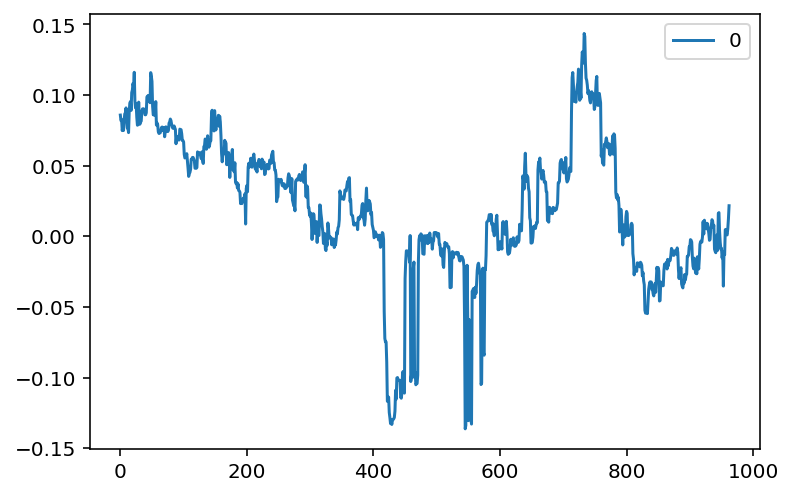

In [80]:
pd.DataFrame(lgb_pred).plot()

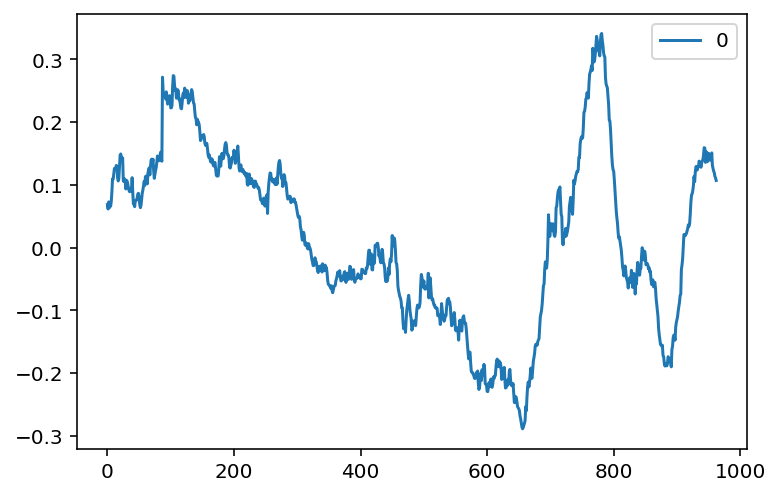

In [81]:
pd.DataFrame(y_pred).plot()

In [78]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

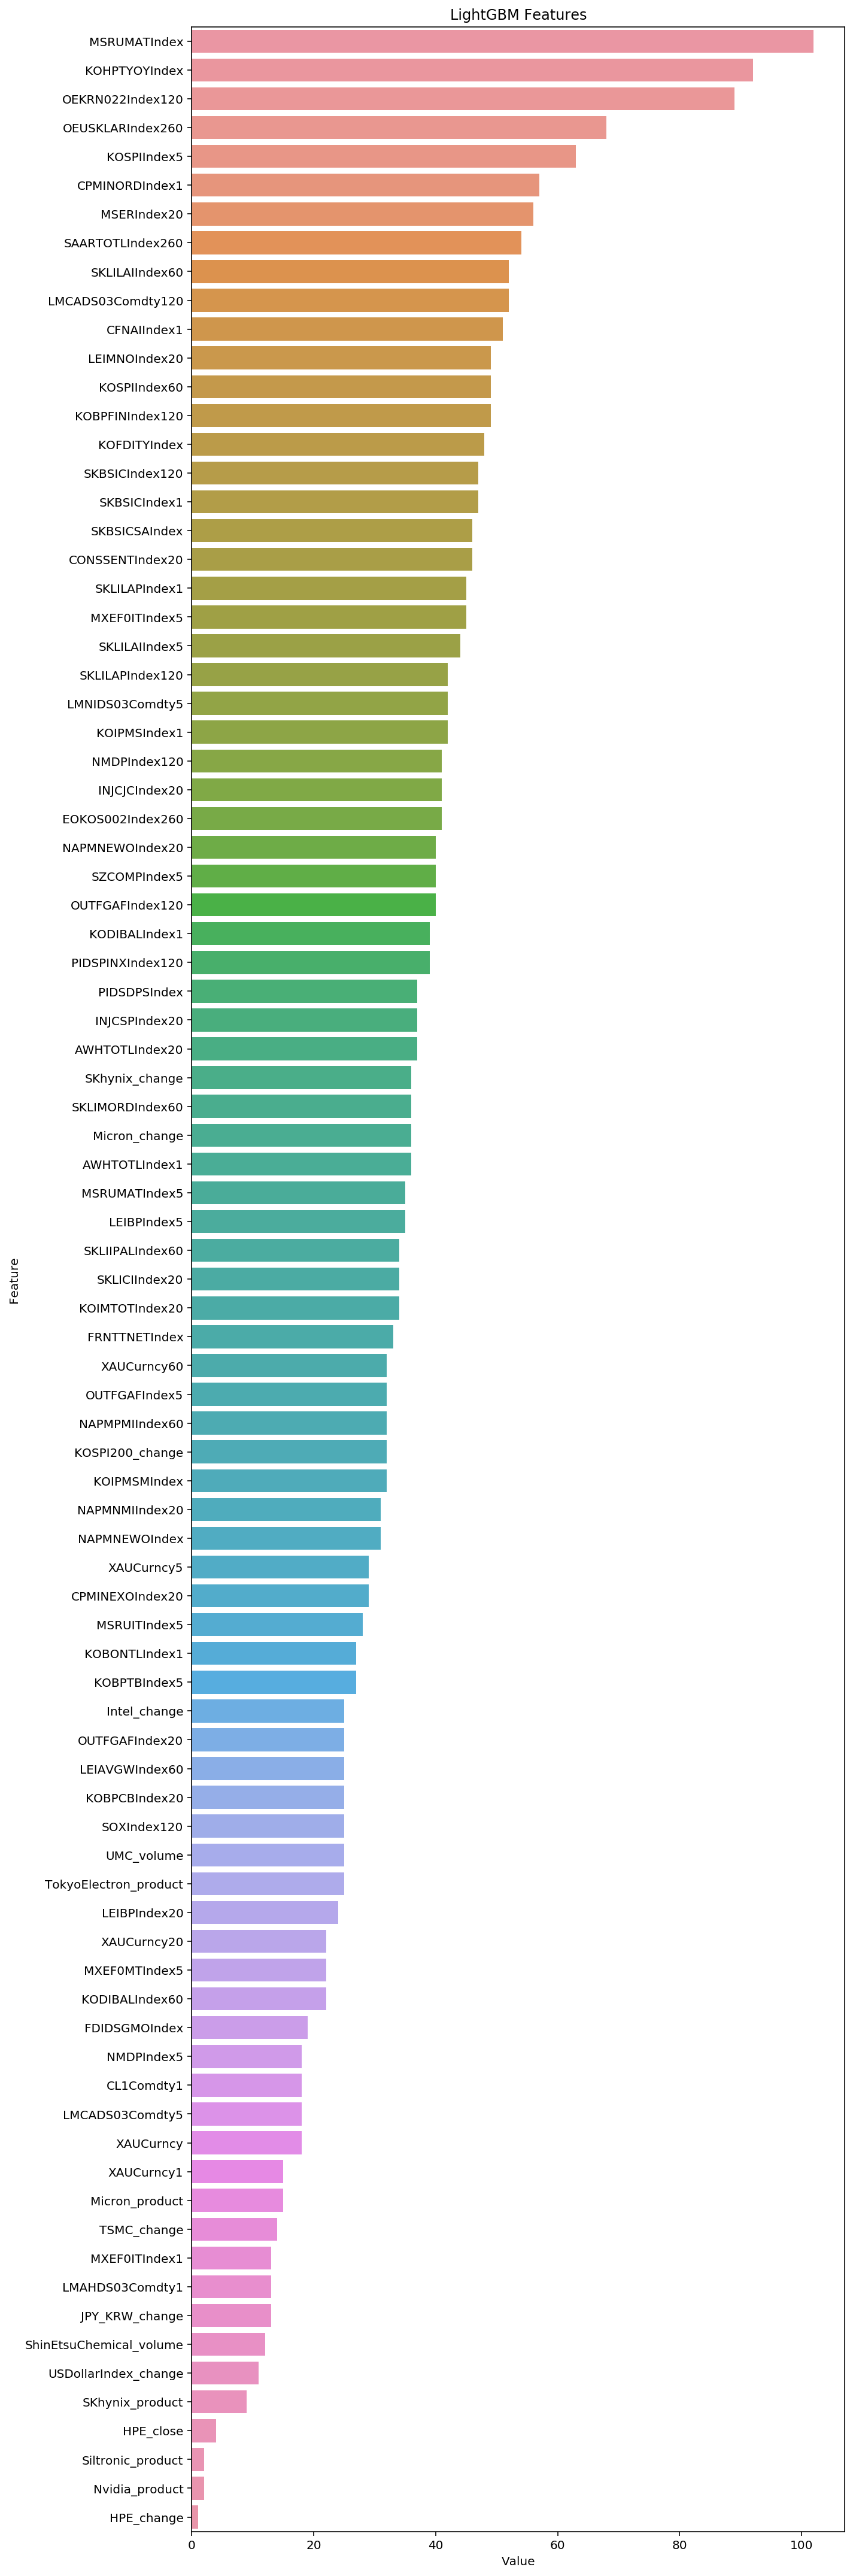

In [88]:
feat_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
feat_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = feat_imp.sort_values(by = 'Value', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_1.png')
plt.show()